<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#k-Nearest-Neighbors" data-toc-modified-id="k-Nearest-Neighbors-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>k-Nearest Neighbors</a></span><ul class="toc-item"><li><span><a href="#Discussion:-Do-you-think-this-kNN-model-is-reliable-for-new-predictions?" data-toc-modified-id="Discussion:-Do-you-think-this-kNN-model-is-reliable-for-new-predictions?-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Discussion: Do you think this kNN model is reliable for new predictions?</a></span></li><li><span><a href="#Discussion:-Which-part-of-the-code-is-training-the-model?-What-are-the-hyperparameters-of-the-model?" data-toc-modified-id="Discussion:-Which-part-of-the-code-is-training-the-model?-What-are-the-hyperparameters-of-the-model?-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Discussion: Which part of the code is training the model? What are the hyperparameters of the model?</a></span></li><li><span><a href="#kNN-advantages-and-disadvantages" data-toc-modified-id="kNN-advantages-and-disadvantages-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>kNN advantages and disadvantages</a></span></li></ul></li><li><span><a href="#Naive-Bayes-Classification" data-toc-modified-id="Naive-Bayes-Classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Naive Bayes Classification</a></span><ul class="toc-item"><li><span><a href="#Discussion:-Is-Naive-Bayes-a-parametric-or-non-parametric-model?" data-toc-modified-id="Discussion:-Is-Naive-Bayes-a-parametric-or-non-parametric-model?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Discussion: Is Naive Bayes a parametric or non-parametric model?</a></span></li><li><span><a href="#Naive-Bayes-advantages-and-disadvantages:" data-toc-modified-id="Naive-Bayes-advantages-and-disadvantages:-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Naive Bayes advantages and disadvantages:</a></span></li></ul></li><li><span><a href="#Decision-Trees" data-toc-modified-id="Decision-Trees-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Discussion:-Which-variable-is-most-important-for-determining-whether-or-not-a-material-will-form-a-perovskite?" data-toc-modified-id="Discussion:-Which-variable-is-most-important-for-determining-whether-or-not-a-material-will-form-a-perovskite?-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Discussion: Which variable is most important for determining whether or not a material will form a perovskite?</a></span></li><li><span><a href="#Decision-trees-advantages-and-disadvantages:" data-toc-modified-id="Decision-trees-advantages-and-disadvantages:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Decision trees advantages and disadvantages:</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

In [2]:
import numpy as np
import pandas as pd

clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233'])

# Alternate classification methods

In the prior lectures we have discussed discriminative "generalized linear" models in depth, and derived and studied the "support vector machine" model. In this lecture we will look at some fundamentally different approaches to the classification problem. While we will not derive these methods or study them in depth, we will introduce the key concepts and see how they work for the toy datasets.

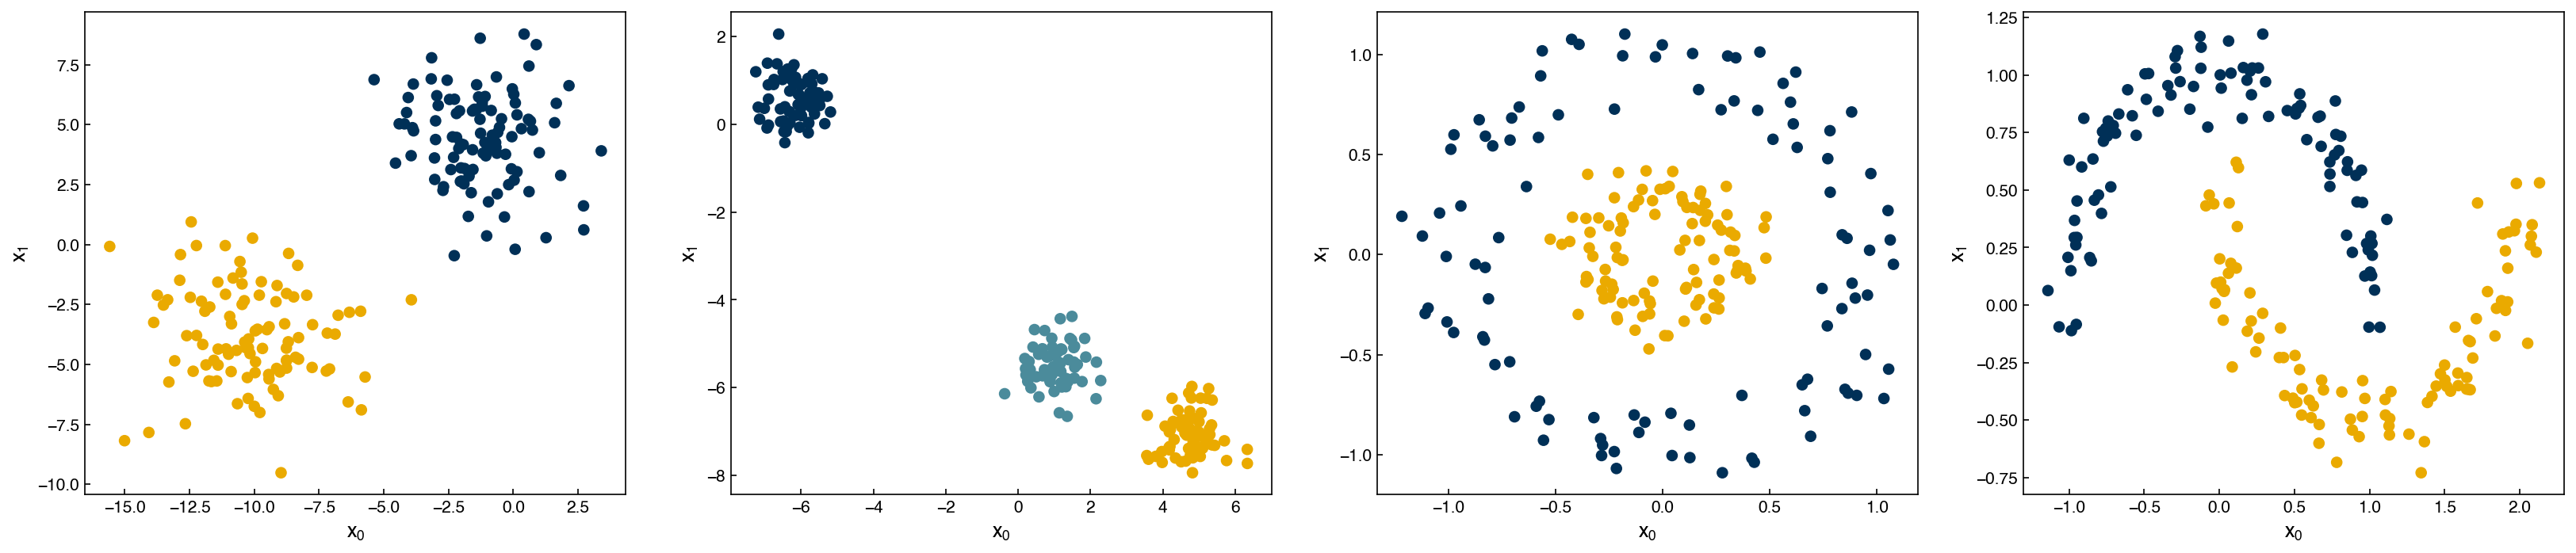

In [3]:
from sklearn.datasets import make_blobs, make_moons, make_circles
np.random.seed(1) #make sure the same random samples are generated each time

noisiness = 1

X_blob, y_blob = make_blobs(n_samples=200, centers=2, cluster_std=2*noisiness, n_features=2)

X_mc, y_mc = make_blobs(n_samples=200, centers=3, cluster_std=0.5*noisiness, n_features=2)

X_circles, y_circles = make_circles(n_samples=200, factor=0.3, noise=0.1*noisiness)

X_moons, y_moons = make_moons(n_samples=200, noise=0.1*noisiness)

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

all_datasets = [[X_blob, y_blob],[X_mc, y_mc], [X_circles, y_circles],[X_moons, y_moons]]

for i, Xy_i in enumerate(all_datasets):
    Xi, yi = Xy_i
    axes[i].scatter(Xi[:,0], Xi[:,1], c = clrs[yi])
    axes[i].set_xlabel('$x_0$')
    axes[i].set_ylabel('$x_1$')
    
plt.show()

## k-Nearest Neighbors

An alternative non-linear classification method is the k-nearest neighbors algorithm. This operates on a principle that is very easy to understand: democracy.

The class of a point is determined by letting its k-nearest neighbors "vote" on which class it should be in. The point is assigned to whichever class has the most votes. In the case of a tie, `k` is decreased by 1 until the tie is broken.

The advantage of democracy is that it is "nonlinear" - we can distinguish classes with very complex structures.

We need 3 functions to implement kNN:

* distance metric - calculate the distance between 2 points. We will use the Euclidean distance.
* get neighbors - find the k points nearest to a given point.
* assign class - poll the neighbors to assign the point to a class

In [4]:
def distance(x1, x2):
    # we will use the numpy 2-norm to calculate Euclidean distance:
    return np.linalg.norm(x1 - x2, 2) #<- the 2 is optional here since 2 is the default.

In [5]:
def get_neighbor_idxs(x, x_list, k):
    dist_pairs = []
    for i,xi in enumerate(x_list):
        dist = distance(x, xi)
        dist_pairs.append([dist, i, xi]) #<- gives us the distance for each point
    dist_pairs.sort() #<- sort by distance
    k_dists = dist_pairs[:k] #<- take the k closest points
    kNN_idxs = [i for di, i, xi in k_dists] #<- we will get the indices of neighbors instead of the point itself.
    return kNN_idxs

In [6]:
from scipy.stats import mode

def assign_class(x, x_list, y_list, k): #<- now we need to know the responses
    neighbors = get_neighbor_idxs(x, x_list, k)
    y_list = list(y_list) #<- this ensures that indexing works properly if y_list is a `pandas` object.
    votes = [y_list[i] for i in neighbors]
    assignment = mode(votes)[0][0] #<- we won't deal with ties for this simple implementation
    return assignment

Now we can "wrap" all of these functions into a single function that predicts the class of an array of points:

In [7]:
def kNN(X, k, X_train, y_train):
    y_out = []
    for xi in X:
        y_out.append(assign_class(xi, X_train, y_train, k))
    y_out = np.array(y_out)
    return y_out

Let's see how this works on some of our toy datasets:

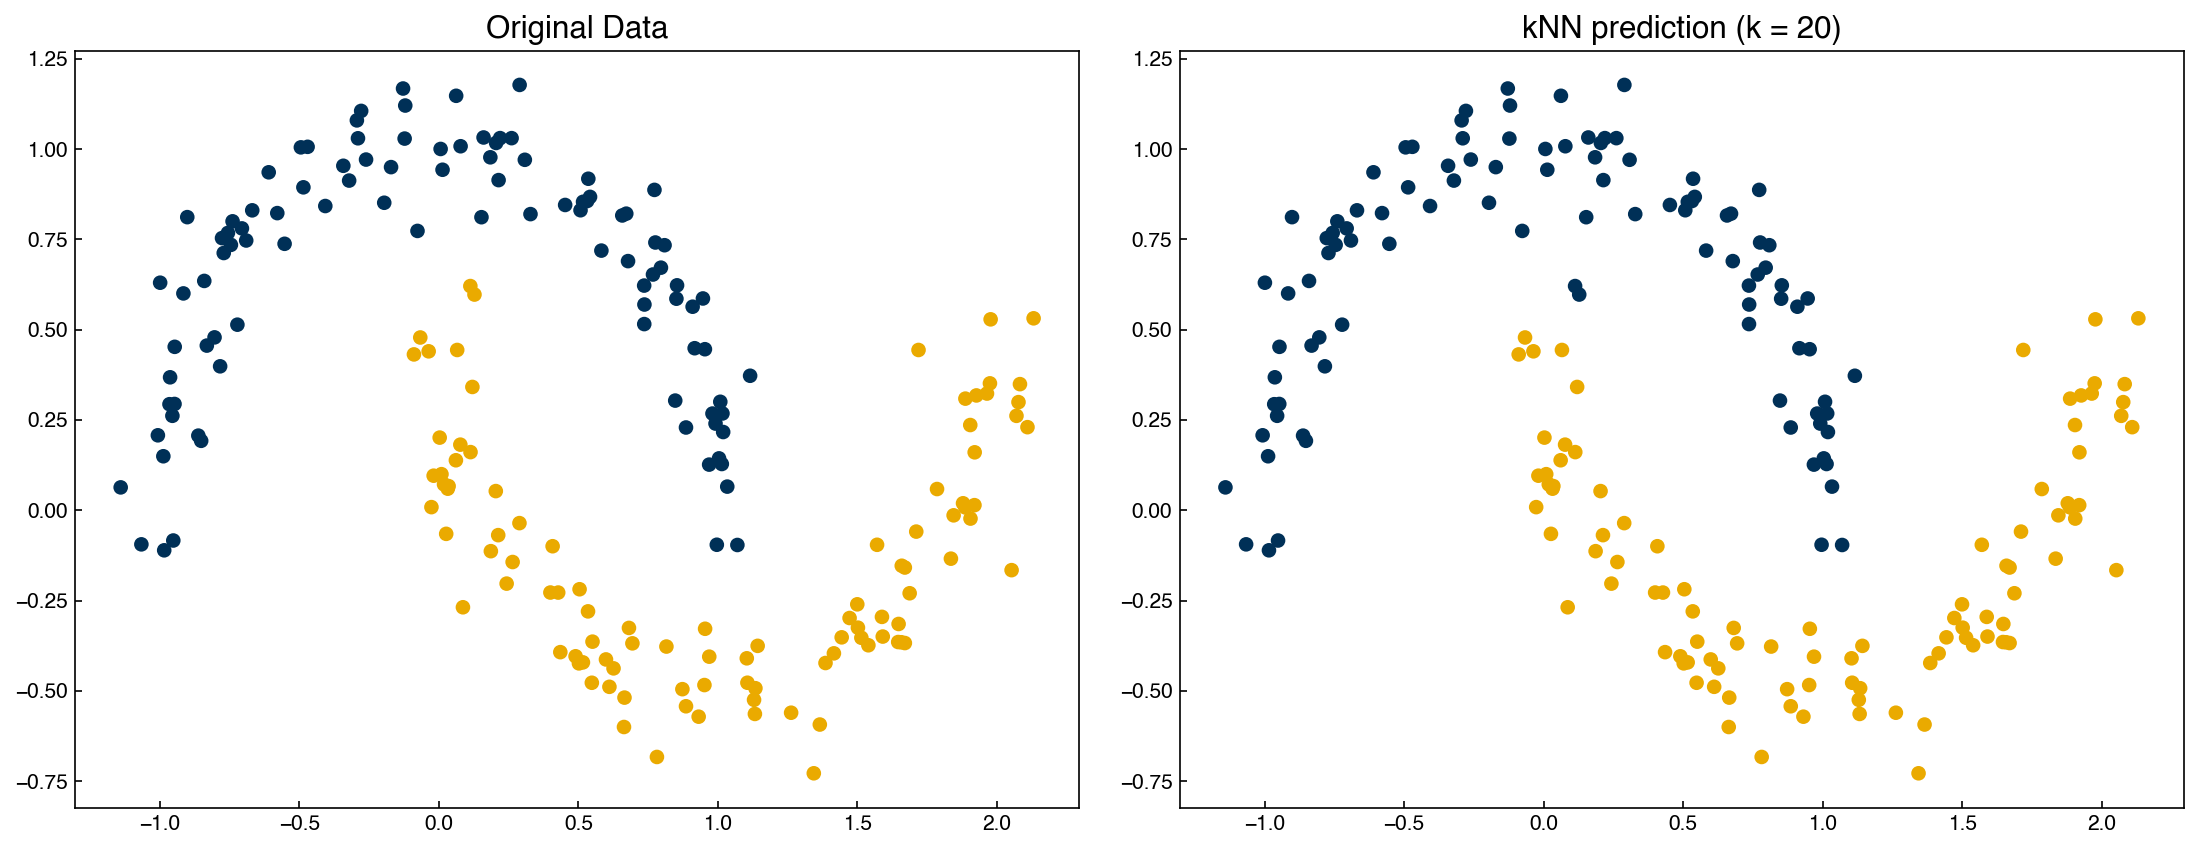

In [8]:
X = X_moons
y = y_moons

y_knn = kNN(X, 20, X, y)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y])
axes[0].set_title('Original Data')
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[y_knn])
axes[1].set_title('kNN prediction (k = 20)');

We see that the kNN model predicts the classes perfectly!

### Discussion: Do you think this kNN model is reliable for new predictions?

> No. This model may be overfitted to the whole `X` data.

Let's try to visualize the model:

In [9]:
def visualize_neighbors(X, X_train, k):
    ## helper function to visualize neighbors
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], color = 'k', alpha = 0.2)
    ax.scatter(X_train[:, 0], X_train[:, 1], color = 'r', alpha = 0.2)
    for xi in X:
        neighbors = get_neighbor_idxs(xi, X_train, k)
        for nj in neighbors:
            xj = X_train[nj]
            ax.plot([xi[0], xj[0]], [xi[1], xj[1]], ls = '-', color = 'b', alpha = 0.2)

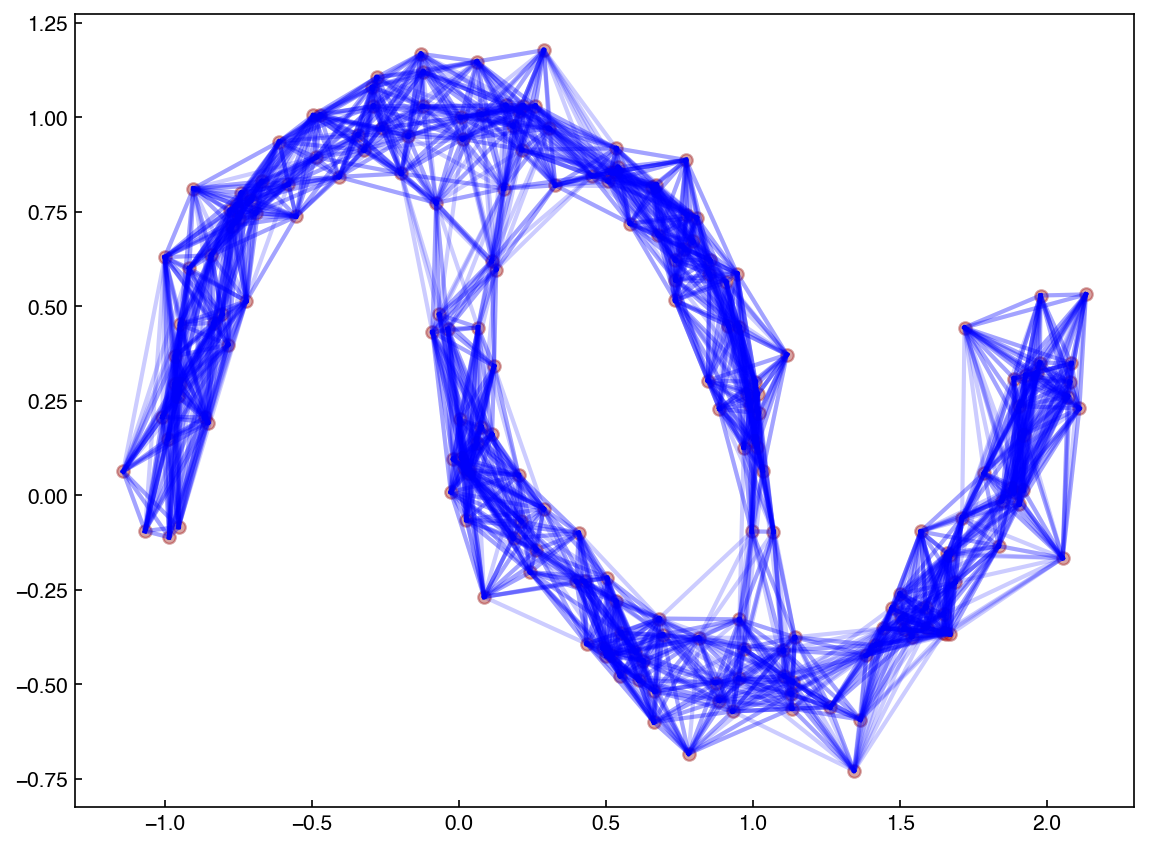

In [10]:
visualize_neighbors(X, X, 20)

The model works well, but all of the points are training points. This means that the model has "memorized" the classes of each point, and then just uses all the data to predict the class. Let's see what happens if we use a test-train split:

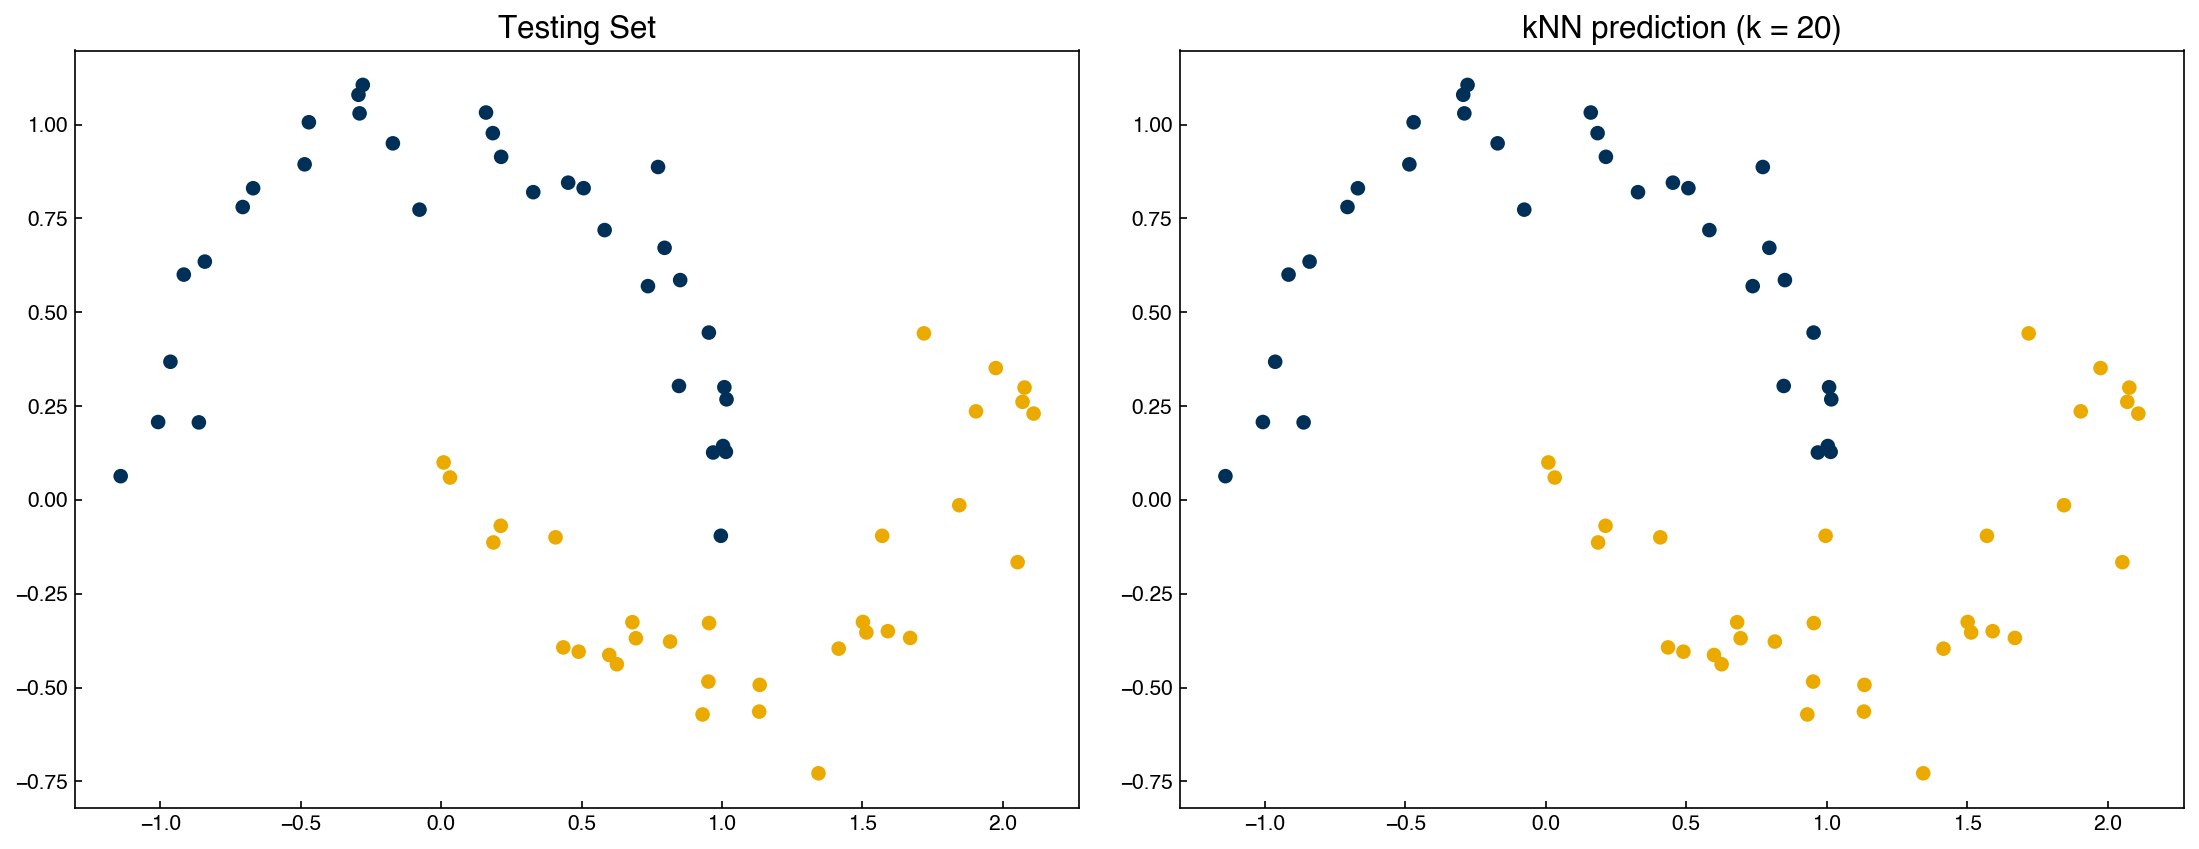

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

y_knn = kNN(X_test, 20, X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X_test[:,0], X_test[:,1], c = clrs[y_test])
axes[0].set_title('Testing Set')
axes[1].scatter(X_test[:, 0], X_test[:, 1], c = clrs[y_knn])
axes[1].set_title('kNN prediction (k = 20)');

We see that the model still performs very well, even for the testing data.

The kNN approach is very flexible, and can easily be extended to multi-class datasets, although "ties" between different classes may become more likely.

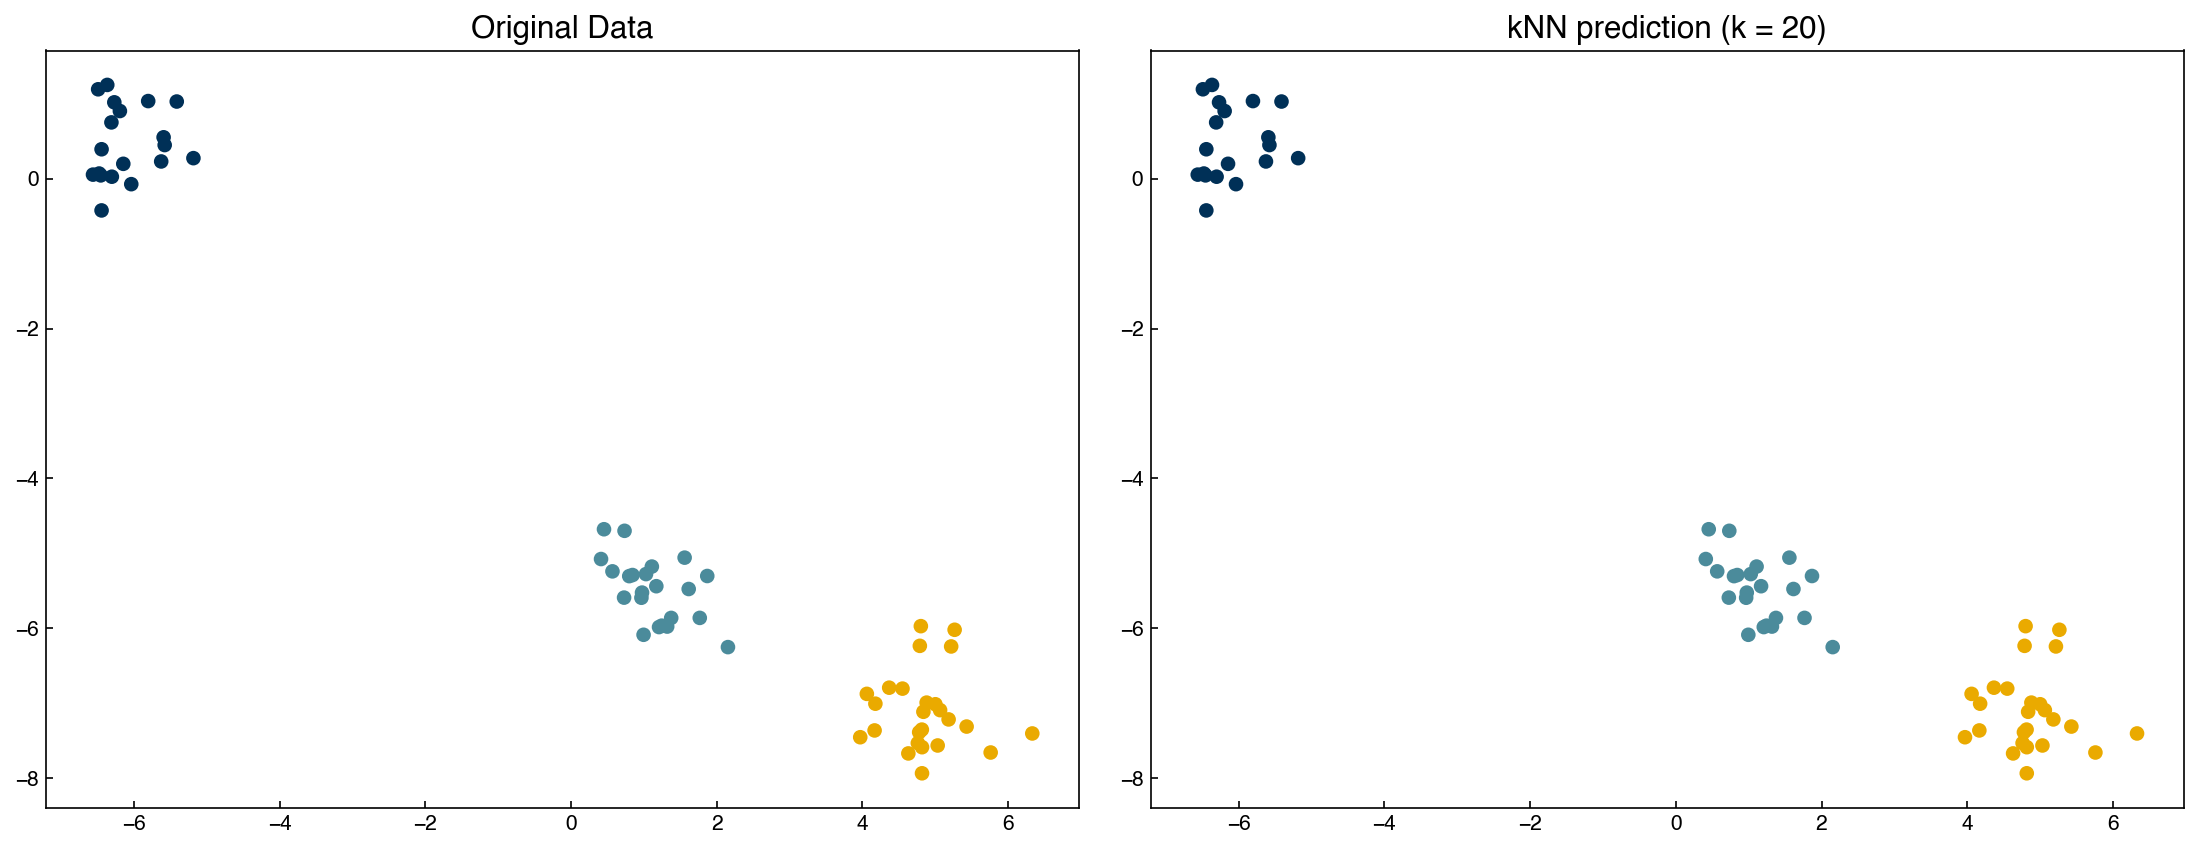

In [12]:
X = X_mc
y = y_mc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

y_knn = kNN(X_test, 20, X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X_test[:, 0], X_test[:, 1], c = clrs[y_test])
axes[0].set_title('Original Data')
axes[1].scatter(X_test[:, 0], X_test[:, 1], c = clrs[y_knn])
axes[1].set_title('kNN prediction (k = 20)');

### Discussion: Which part of the code is training the model? What are the hyperparameters of the model?

>We actually do not train the model. There is no loss function.  
`k` and distance metrics are commonly tuned hyperparameters.

We can also use the `scikit-learn` implementation:

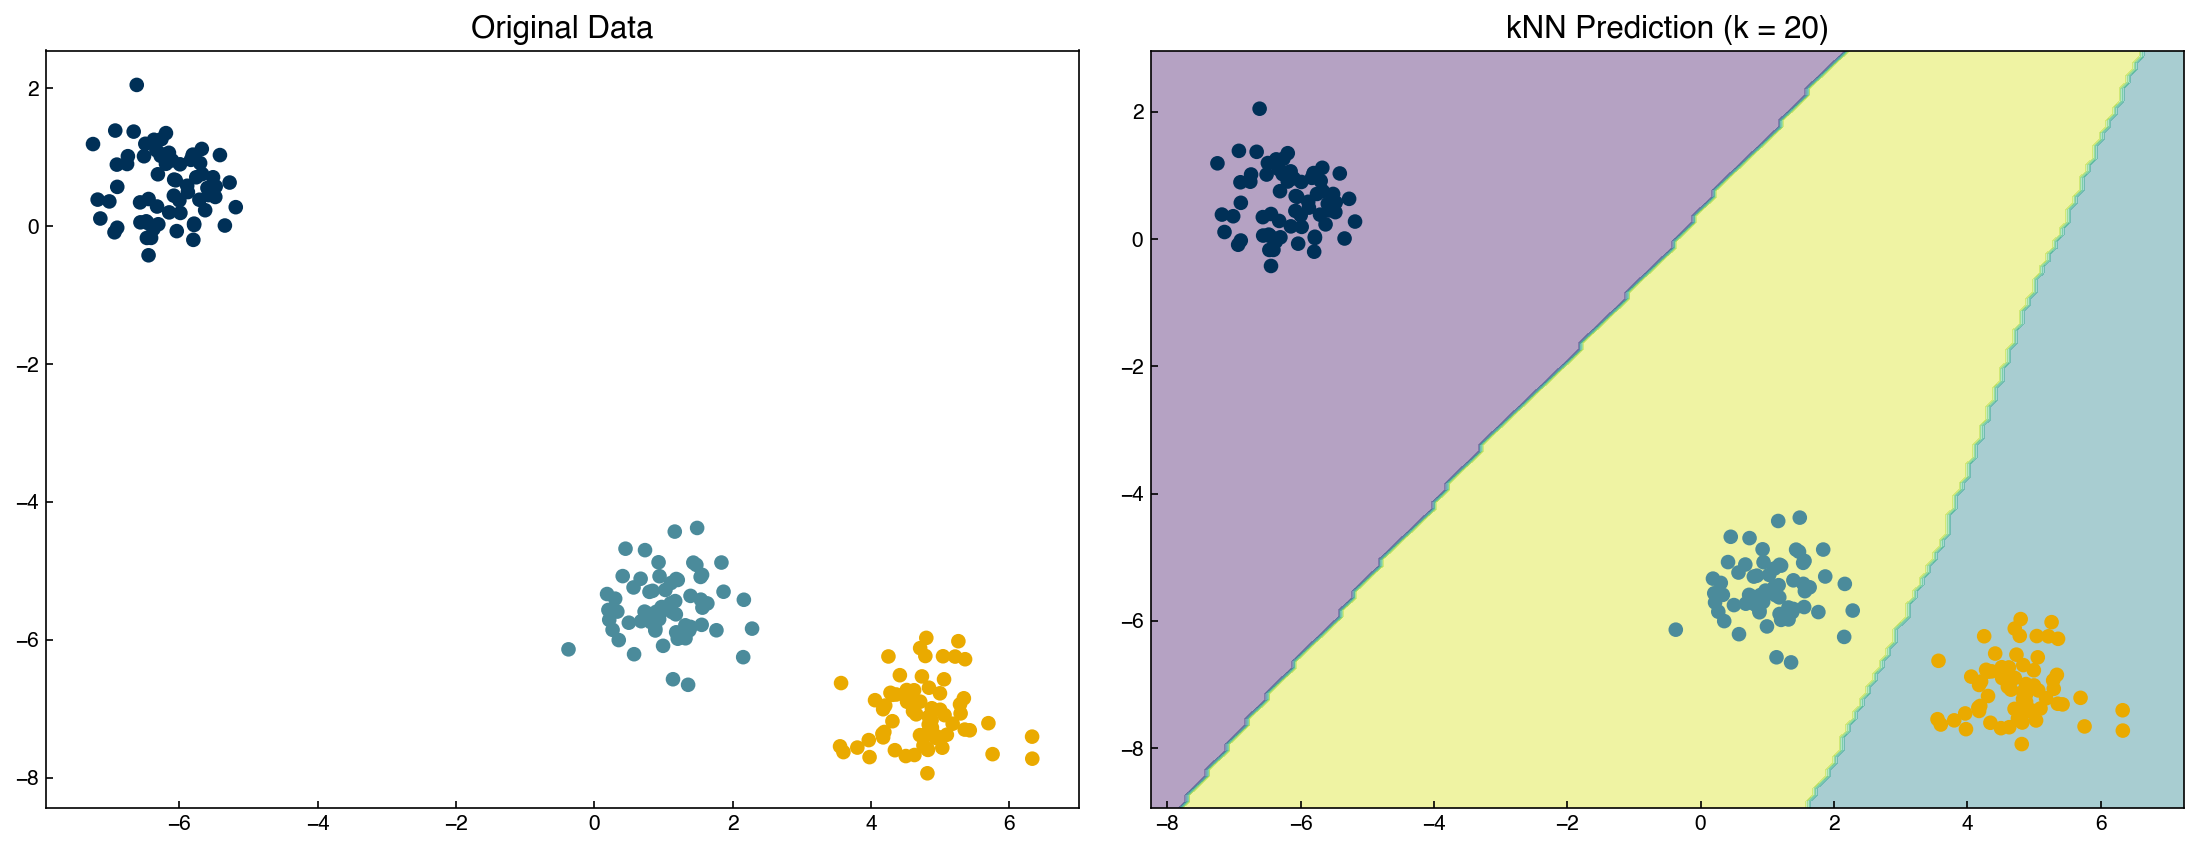

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(X, y)
y_predict = knn.predict(X)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axes[1].contourf(xx, yy, Z, alpha = 0.4)
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[y_predict])
axes[0].set_title('Original Data')
axes[1].set_title('kNN Prediction (k = 20)');

This will make it easier to optimize hyperparameters and compare models. It is also generally more efficient.

### kNN advantages and disadvantages

**Advantages**

* Simple to understand/implement
* Intuitive
* Highly non-linear class boundaries

**Disadvantages**

* Slow for large training sets and/or high dimensions
* Difficult to interpret in high dimensions

## Naive Bayes Classification

A totally different approache is the "Naive Bayes" classifier, which is a generative model. The model is "naive" because it naively assumes that the data in each class follows a Gaussian distribution, and that the features are not correlated. 

Under these assumptions, the Gaussian distribution for each class gives the probability function for $y$ (class) as a function of $X$ (features):

$P(\vec{x}|y_i) \sim \exp\left(\sum_j \frac{(x_j - \mu_i)^2}{2 \sigma_i^2}\right)$

where $\mu_i$ is the mean (centroid) of class $i$, and $\sigma_i$ is the standard deviation of class $i$.

This can be used with Bayes' formula to estimate $P(y_i|\vec{x})$:

$P(y_i|\vec{x}) = \frac{P(\vec{x}|y_i) P(y_i)}{P(\vec{x})}$


The code block below will visualize this. You don't need to understand how it works, but as usual should understand the output:

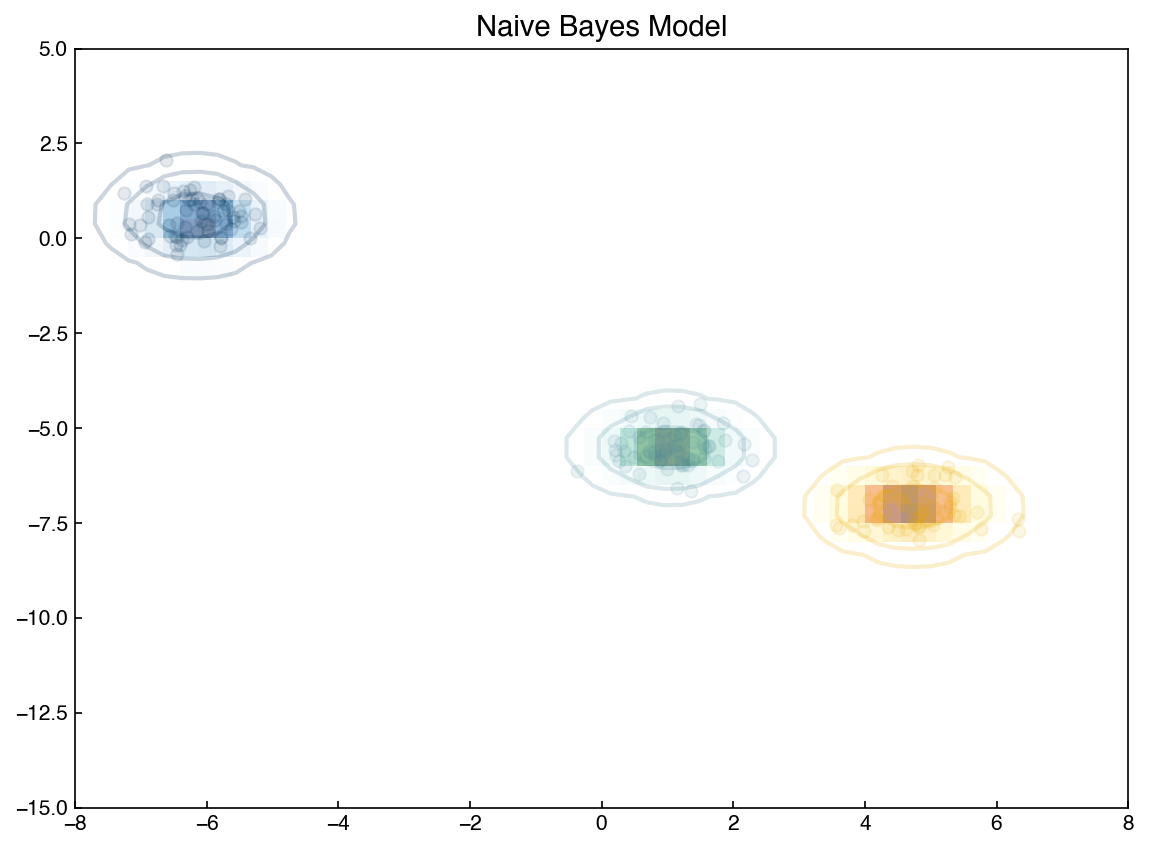

In [14]:
fig, ax = plt.subplots()

ax.set_title('Naive Bayes Model', size = 14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

cmaps = ['Blues', 'YlOrBr', 'BuGn']
## Don't worry if this doesn't exactly make sense
for label, color in enumerate(clrs[:3]):
    mask = y == label
    ax.scatter(X[mask][:, 0], X[mask][:, 1], c = color, alpha = 0.1)
    mu, std = X[mask].mean(0), X[mask].std(0) #<- here is the key part: take the mean/stdev of each class.
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha = 0.5, cmap = cmaps[label])
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels = [0.01, 0.1, 0.5, 0.9],
               colors = color, alpha = 0.2)

This is a *generative model* because we are now (assuming) we know the distribution from which each class was drawn. We can then use this probability distribution to assess the relative probability that any new point belongs to each class.

We will not implement the model here, but will use the `scikit-learn` implementation:

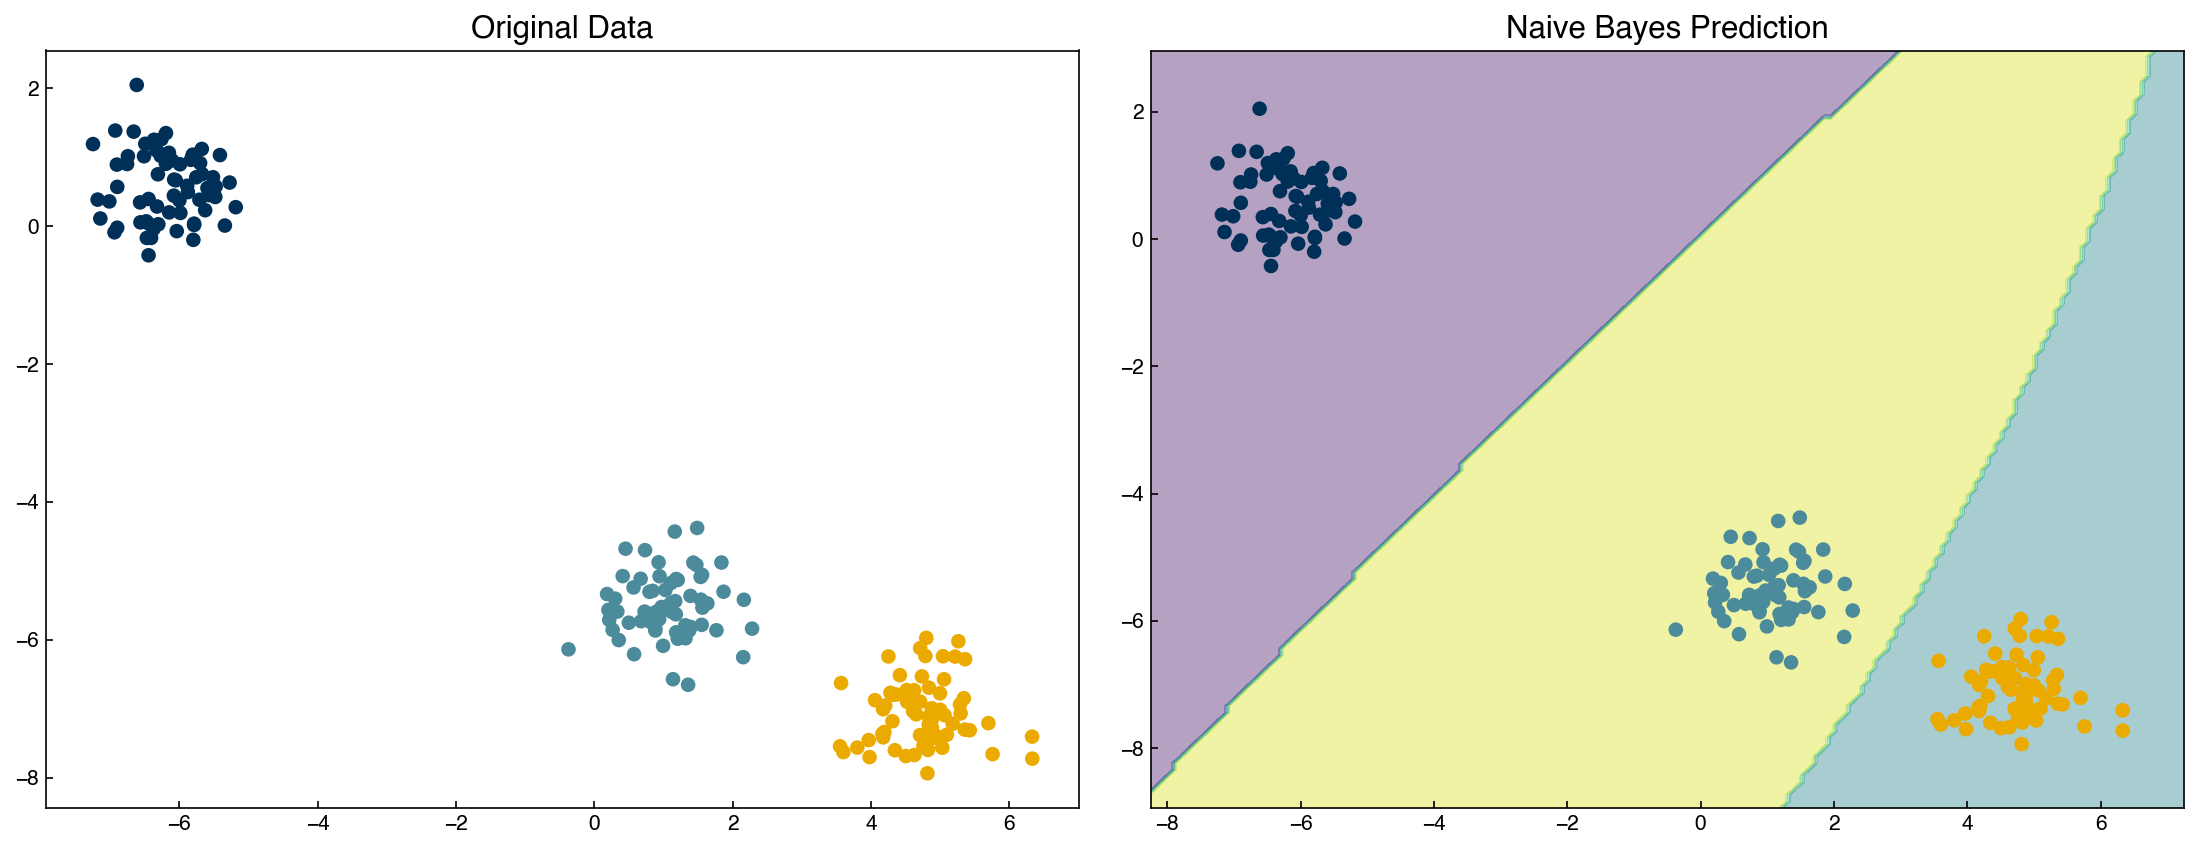

In [15]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(X, y)
y_predict = NB.predict(X)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = NB.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axes[1].contourf(xx, yy, Z, alpha = 0.4)
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[y_predict])
axes[0].set_title('Original Data')
axes[1].set_title('Naive Bayes Prediction');

Naive Bayes works well for linearly-separable datasets where the classes follow Gaussian distributions, but will not work well for highly non-linear datasets. There is a "not so naive" extension that can be used once more sophisticated models for the underlying class distributions are known, but this is beyond the scope of this lecture.

### Discussion: Is Naive Bayes a parametric or non-parametric model?

> It is a parametric model. Naïve Bayes models need the mean and standard deviation for each feature as parameters. Therefore, the number of parameters will depend on the number of features, which will not change due to the size of the dataset.

### Naive Bayes advantages and disadvantages:

**Advantages:**

* Difficult to overfit
* Probabilistic predictions
* Can easily re-sample to correct class imbalance

**Disadvantages:**

* Decision boundaries are quadratic (often nearly linear in practice)

## Decision Trees

Decision trees are a very powerful type of **discriminative** classification algorithm, and they are relatively easy to interpret. They also have the advantage of working well with discrete input variables (e.g. discrete feature spaces). Essentially, a decision tree checks each input variable and attempts to make a discrete "cut" in that variable to decide which class it belongs in. It then repeates this process with other variables until the training data can be separated into the correct classes. In a sense, it breaks the problem into a lot of 1-dimensional classification models and repeats the process recursively. The way that the decision point is determined is slightly different than what we saw for generalized linear models, and is usually based on information theory concepts like gini criteria or information entropy. We will not go into the details here.

The disadvantage of decision trees is that they are very prone to over-fitting, because variables can be used more than once. The "Random forest" approach overcomes this by training an ensemble of decision trees with subsets of the data (similar to the "bootstrapping" we saw before) and using this ensemble of models to produce an estimate.

We will not go into the theory of decision trees here, but we will show a brief example using the toy datasets with the `scikit-learn` implementation.

In [16]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

In [17]:
X = X_mc
y = y_mc

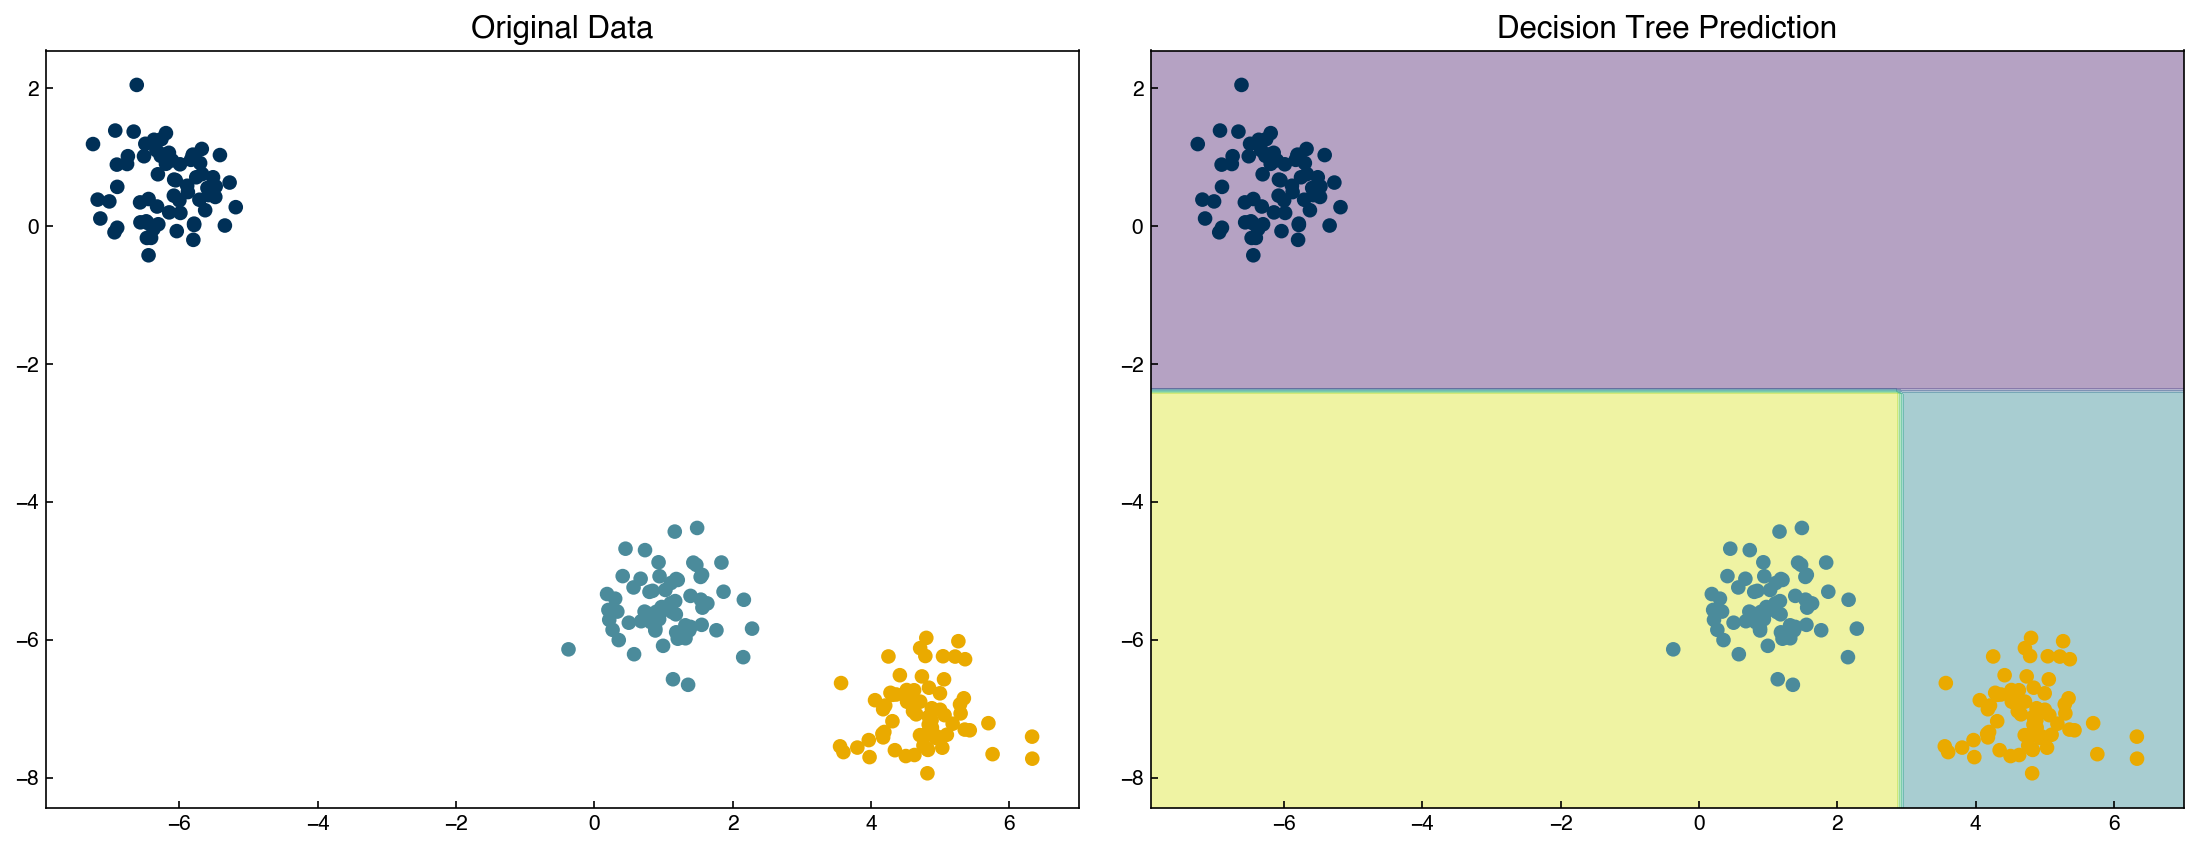

In [18]:
tree.fit(X, y)
y_tree = tree.predict(X)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axes[1].contourf(xx, yy, Z, alpha = 0.4)
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[y_tree])

bottom, top = axes[0].get_ylim()
axes[1].set_ylim(bottom, top)

left, right = axes[0].get_xlim()
axes[1].set_xlim(left, right)

axes[0].set_title('Original Data')
axes[1].set_title('Decision Tree Prediction');

In [19]:
X = X_moons
y = y_moons

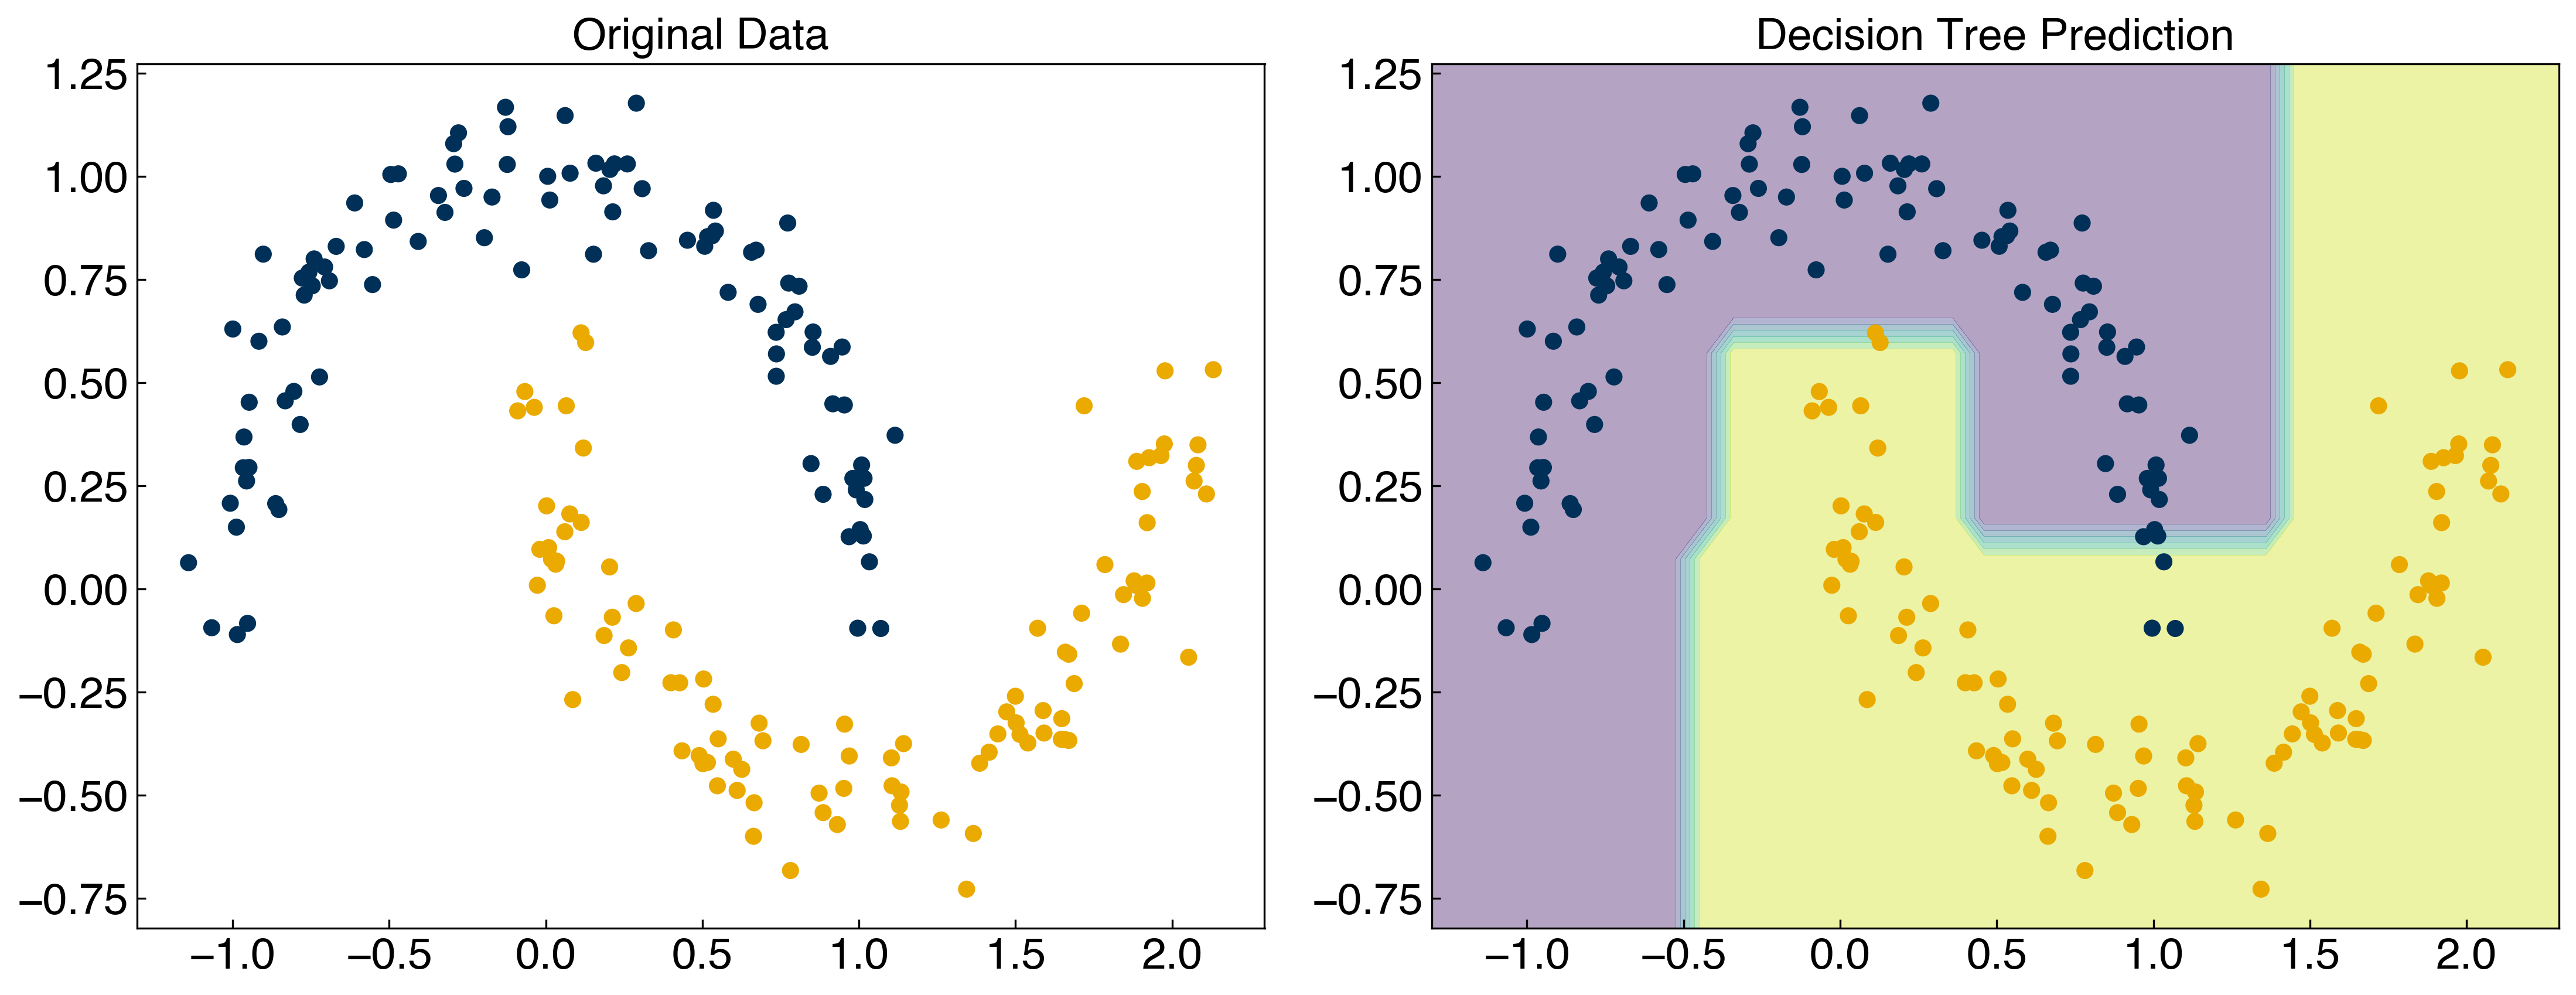

In [20]:
tree.fit(X, y)
y_tree = tree.predict(X)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

axes[1].contourf(xx, yy, Z, alpha = 0.4)
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[y_tree])

bottom, top = axes[0].get_ylim()
axes[1].set_ylim(bottom, top)

left, right = axes[0].get_xlim()
axes[1].set_xlim(left, right)

axes[0].set_title('Original Data')
axes[1].set_title('Decision Tree Prediction');

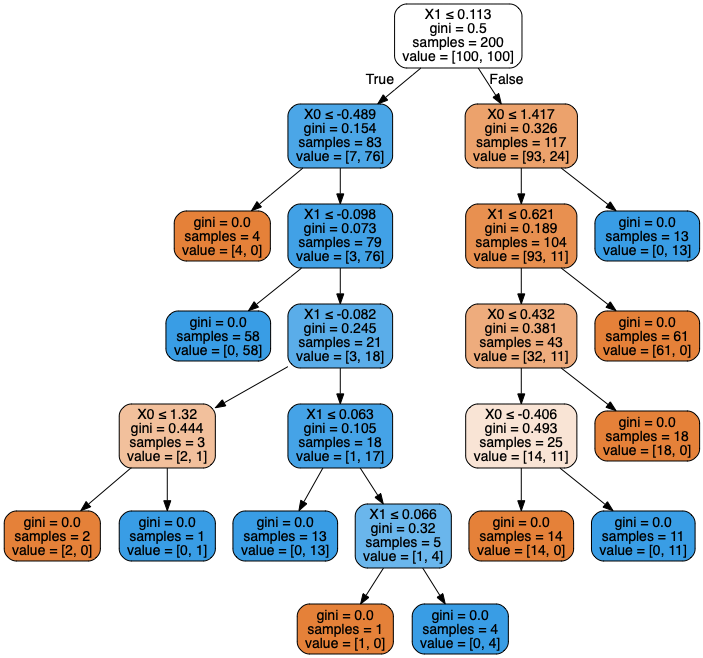

In [21]:
from io import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(tree, out_file = dot_data,  
                filled = True, rounded = True,
                special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Decision trees advantages and disadvantages:

**Advantages:**

* Intuitive interpretation of model
* Able to predict highly non-linear boundaries

**Disadvantages:**

* Easily over-fit
* Training can be expensive for large or high-dimensional data
* Predictions are discrete rather than continuous (boundaries are not smooth)

## Conclusion

There are many types of classification algorithms available, but most are based on concepts similar to these. In practice, it is typical to compare the performance, training time, and prediction time for various classifiers to determine the best model, since it can be difficult to predict which approach will be best.